In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import pandas as pd
import numpy as np
from datetime import datetime
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from keras import backend
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.sequence import TimeseriesGenerator


import utils

Using plaidml.keras.backend backend.


In [2]:
val_split = 0.2

train, test = utils.load_data(random=False, hourly=True)

# train = utils.one_hot_calendar_vals(train)
# test = utils.one_hot_calendar_vals(test)

vidx = int(len(train) * (1 - val_split))
train, validate = train[vidx:], train[:vidx]
train.head()

,target,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,...,day_of_year,weekday,week,month,hour,cloud_cover_BKN,cloud_cover_CLR,cloud_cover_FEW,cloud_cover_OVC,cloud_cover_SCT
2017-07-14 05:00:00,6196.292,66.0,65.0,66.0,96.0,30.03,8.0,66.0,50.0,15.0,...,195,4,28,7,5,0,0,0,1,0
2017-07-14 06:00:00,6525.258,65.0,64.0,65.0,97.0,30.05,10.0,65.0,70.0,13.0,...,195,4,28,7,6,0,0,0,1,0
2017-07-14 07:00:00,6934.592,65.0,64.0,65.0,97.0,30.07,5.0,65.0,70.0,8.0,...,195,4,28,7,7,0,0,0,1,0
2017-07-14 08:00:00,7249.992,65.0,64.0,65.0,97.0,30.06,6.0,65.0,80.0,10.0,...,195,4,28,7,8,0,0,0,1,0
2017-07-14 09:00:00,7463.567,66.0,64.0,66.0,93.0,30.07,8.0,66.0,60.0,10.0,...,195,4,28,7,9,0,0,0,1,0


In [3]:
train_labels = np.array(train['target']).reshape(-1, 1)
train.drop(columns=['target'], inplace=True)

validate_labels = np.array(validate['target']).reshape(-1, 1)
validate.drop(columns=['target'], inplace=True)

test_labels = np.array(test['target']).reshape(-1, 1)
test.drop(columns=['target'], inplace=True)

cols = train.columns

In [4]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
validate = scaler.transform(validate)
test = scaler.transform(test)

label_scaler = StandardScaler()
train_labels = label_scaler.fit_transform(train_labels)
validate_labels = label_scaler.transform(validate_labels)
test_labels = label_scaler.transform(test_labels)

In [5]:
# shift the target samples by one step to the right so that TSGen picks up correct label

train_labels = np.insert(train_labels, 0, 0)[:-1]
validate_labels = np.insert(validate_labels, 0, 0)[:-1]
test_labels = np.insert(test_labels, 0, 0)[:-1]

In [6]:
timesteps = 12  # try using previous 4 days (4x24)
steps_ahead = 1
epochs = 5

train_gen = TimeseriesGenerator(train, train_labels, length=timesteps,
                                sampling_rate=1, batch_size=steps_ahead)
validate_gen = TimeseriesGenerator(validate, validate_labels, length=timesteps,
                              sampling_rate=1, batch_size=steps_ahead)

# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [14]:
model = Sequential()

input_shape = (timesteps, train.shape[1])

model.add(layers.LSTM(16, input_shape=input_shape))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, name='output'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

In [15]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    workers=4,
    validation_data=validate_gen
)

Epoch 1/5
23697/23697 [==============================] - 452s 19ms/step - loss: 0.1384 - mean_absolute_error: 0.2750 - val_loss: 0.7982 - val_mean_absolute_error: 0.5687
Epoch 2/5
23697/23697 [==============================] - 360s 15ms/step - loss: 0.0851 - mean_absolute_error: 0.2159 - val_loss: 0.6774 - val_mean_absolute_error: 0.5496
Epoch 3/5
23697/23697 [==============================] - 457s 19ms/step - loss: 0.0802 - mean_absolute_error: 0.2081 - val_loss: 0.5359 - val_mean_absolute_error: 0.4938
Epoch 4/5
23697/23697 [==============================] - 410s 17ms/step - loss: 0.0725 - mean_absolute_error: 0.1981 - val_loss: 0.4550 - val_mean_absolute_error: 0.4548
Epoch 5/5
23697/23697 [==============================] - 384s 16ms/step - loss: 0.0716 - mean_absolute_error: 0.1955 - val_loss: 0.5514 - val_mean_absolute_error: 0.4906


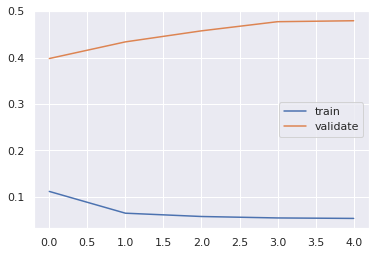

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()

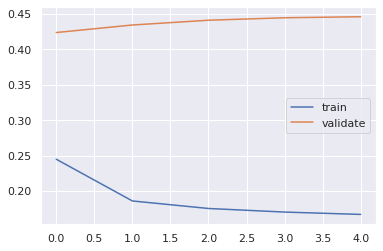

In [10]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validate')
plt.legend()
plt.show()

In [11]:
test_gen = TimeseriesGenerator(test, test_labels, length=timesteps,
                                sampling_rate=1, batch_size=steps_ahead)

pred = model.predict_generator(test_gen)

In [12]:
# get the ISO hourly forecasts and clean them up
isolf = utils.isolf_hourly()

# get predictions made on day X for day X (which means the forecast for day X posted on day X)
isolf = isolf.loc[isolf['date_pred_for'].dt.date == isolf['date_pred_made'].dt.date]
isolf = isolf.set_index('date_pred_for')

In [13]:
# results = test.join(isolf, how='inner')
# results['prediction'] = predictions
# results['target'] *= std.target
# results['target'] += mean.target
# results['prediction'] *= std.target
# results['prediction'] += mean.target

# results['date'] = results.index
# results = results.astype({'prediction': 'float'})

# results, pred_plot = model_scoring.eval(results)

AttributeError: 'numpy.ndarray' object has no attribute 'join'